# Import Necessary packages

In [1]:
import numpy as np
from imutils import perspective
from scipy.spatial import distance as dist
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from scipy.spatial import distance
import tensorflow as tf
from zipfile import ZipFile
from natsort import natsorted
from tensorflow import keras

# Bounding box for each tooth

In [2]:
def rearrange(tl,tr,br,bl):
    my_list = [tl,tr,br,bl]
    my_list_sorted = sorted(my_list, key=lambda x:x[1])
    
    top_list = [my_list_sorted[0],my_list_sorted[1]]
    
    top_list_sorted = sorted(top_list, key=lambda x:x[0])
    
    bottom_list = [my_list_sorted[2],my_list_sorted[3]]
    
    bottom_list_sorted = sorted(bottom_list, key=lambda x:x[0])
    
    
    return top_list_sorted[0], top_list_sorted[1], bottom_list_sorted[1], bottom_list_sorted[0]

def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

def CCA_Analysis(orig_image,predict_image,erode_iteration,open_iteration):
    
    box_list = []
    kernel1 =( np.ones((5,5), dtype=np.float32))
    kernel_sharpening = np.array([[-1,-1,-1], 
                                  [-1,9,-1], 
                                 [-1,-1,-1]])
    image = predict_image
    image2 = np.copy(orig_image)    
    image=cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel1,iterations=open_iteration )
    image = cv2.filter2D(image, -1, kernel_sharpening)
    image=cv2.erode(image,kernel1,iterations =erode_iteration)
    #image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    labels=cv2.connectedComponents(thresh,connectivity=4)[1] 
    a=np.unique(labels)
    
    count2=0
    for label in a:
        if label == 0:
            continue
    
        # Create a mask
        mask = np.zeros(thresh.shape, dtype="uint8")
        mask[labels == label] = 255
        # Find contours and determine contour area
        cnts,hieararch = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        cnts = cnts[0]
        c_area = cv2.contourArea(cnts)
        # threshhold for tooth count
        if c_area>4000:
            count2+=1
        
            (x,y),radius = cv2.minEnclosingCircle(cnts)
            rect = cv2.minAreaRect(cnts)
            box = cv2.boxPoints(rect)
            box = np.array(box, dtype="int")    
            box = perspective.order_points(box)
            color1 = (list(np.random.choice(range(150), size=3)))  
            color =[int(color1[0]), int(color1[1]), int(color1[2])]  
            cv2.drawContours(image2,[box.astype("int")],0,color,2)
            (tl,tr,br,bl)=box
            tl_new,tr_new,br_new,bl_new = rearrange(tl,tr,br,bl)
            
            #box_list.append(box)
            
            box_list.append((tl_new,tr_new,br_new,bl_new))

            (tltrX,tltrY)=midpoint(tl,tr)
            (blbrX,blbrY)=midpoint(bl,br)
            # compute the midpoint between the top-left and top-right points,
            # followed by the midpoint between the top-righ and bottom-right
            (tlblX,tlblY)=midpoint(tl,bl)
            (trbrX,trbrY)=midpoint(tr,br)
            # draw the midpoints on the image
            cv2.circle(image2, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
            cv2.circle(image2, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
            cv2.circle(image2, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
            cv2.circle(image2, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
            cv2.line(image2, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),color, 2)
            cv2.line(image2, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),color, 2)
            dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
            dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

        
        
            pixelsPerMetric=1
            dimA = dA * pixelsPerMetric
            dimB = dB *pixelsPerMetric
            #cv2.putText(image2, "{:.1f}pixel".format(dimA),(int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,0.65, color, 2)
            #cv2.putText(image2, "{:.1f}pixel".format(dimB),(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,0.65, color, 2)
            #cv2.putText(image2, "{:.1f}".format(label),(int(tltrX - 35), int(tltrY - 5)), cv2.FONT_HERSHEY_SIMPLEX,0.65, color, 2)
    teeth_count=count2
    return image2,teeth_count, box_list

# Panoramic Image Preprocessing

In [3]:
def convert_one_channel(img):
    #some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img
def pre_images_sbmi(resize_shape,path,include_zip):
    
    path=path + '/pan_images/'
    name_list = []
    dirs=natsorted(os.listdir(path))
    
    sizes=np.zeros([len(dirs),2])
    name_list.append(dirs[0])
    images=img=Image.open(path+dirs[0])
    sizes[0,:]=images.size
    images=(images.resize((resize_shape),Image.ANTIALIAS))
    images=convert_one_channel(np.asarray(images))
    
    for i in range (1,len(dirs)):
        name_list.append(dirs[i])
        img=Image.open(path+dirs[i])
        sizes[i,:]=img.size
        img=img.resize((resize_shape),Image.ANTIALIAS)
        img=convert_one_channel(np.asarray(img))
        #img=np.asarray(img)
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(dirs),resize_shape[0],resize_shape[1],1))
    return images,sizes, name_list
#pre_images(resize_shape,path,include_zip)


# Load Model and Predict Mask

In [4]:
#model = tf.keras.models.load_model('models/my_model.h5')
model = keras.models.load_model('models/Fourth_pan_model_BS_24_epoch_150.h5')

original_image_X,original_image_X_sizes, name_list=pre_images_sbmi((512,512),"sample_images",True)

print(original_image_X.shape)

original_image_X=np.float32(original_image_X/255)

predict_img=model.predict(original_image_X)
print(predict_img.shape)

plt.imsave('sample_images/masks/10.png',predict_img[0,:,:,0])

(1, 512, 512, 1)
(1, 512, 512, 1)


# Display some image, model generated mask and tooth count

(1220, 2914)
(512, 512)
(1220, 2914)
24


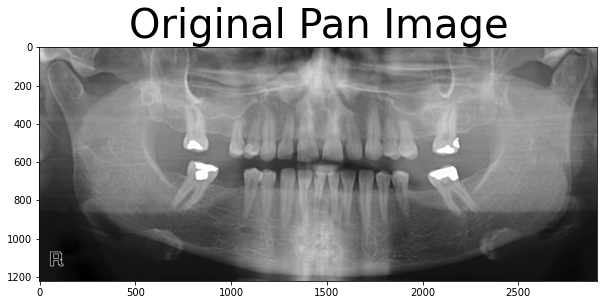

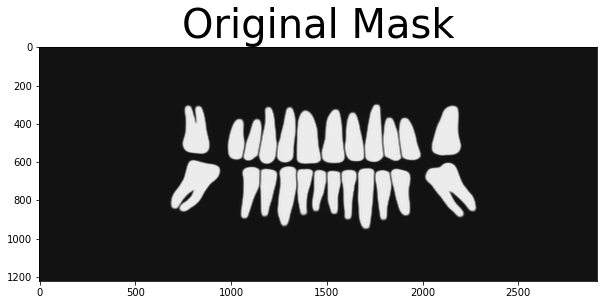

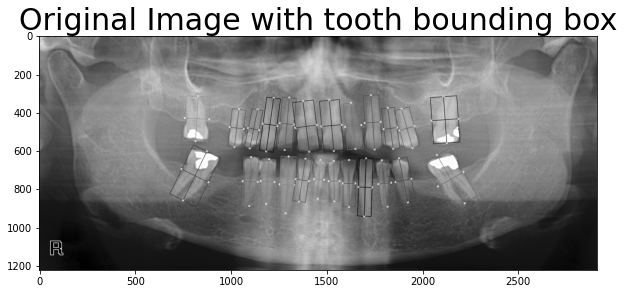

In [6]:
original_image = cv2.imread("sample_images/pan_images/10.png",0)
print(original_image.shape)


original_image_mask = cv2.imread("sample_images/masks/10.png",0)
print(original_image_mask.shape)

original_image_mask = cv2.resize(original_image_mask, (original_image.shape[1],original_image.shape[0]), interpolation=cv2.INTER_LANCZOS4)
print(original_image_mask.shape)

cca_result,teeth_count, box_list = CCA_Analysis(original_image,original_image_mask,3,2)


print(teeth_count)
plt.figure(figsize = (10,10))
plt.title("Original Pan Image",fontsize = 40)
plt.imshow(original_image, cmap= 'gray')

plt.figure(figsize = (10,10))
plt.title("Original Mask",fontsize = 40)
plt.imshow(original_image_mask, cmap= 'gray')

plt.figure(figsize = (10,10))
plt.title("Original Image with tooth bounding box",fontsize = 30)
plt.imshow(cca_result, cmap= 'gray')



# Upper Lower tooth seperate from left to right

In [7]:
upper_tooth = []
lower_tooth = []

total_average = 0.0
for pp in range(len(box_list)):
    total_average = total_average  + box_list[pp][0][1]
mean_avg_y_axis = total_average/len(box_list)
for pp in range(len(box_list)):
    if box_list[pp][0][1]< mean_avg_y_axis:
        upper_tooth.append(box_list[pp])
    else:
        lower_tooth.append(box_list[pp])


upper_tooth_sorted = sorted(upper_tooth, key=lambda x:x[0][0])
lower_tooth_sorted = sorted(lower_tooth, key=lambda x:x[0][0])

print("Total Upper tooth:",len(upper_tooth_sorted), ", Total Lower tooth:",len(lower_tooth_sorted))




Total Upper tooth: 12 , Total Lower tooth: 12


# Save upper tooth from self panoramic image for self-matching 

12


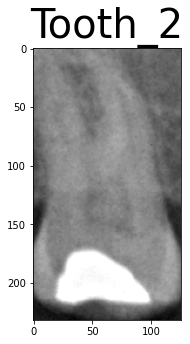

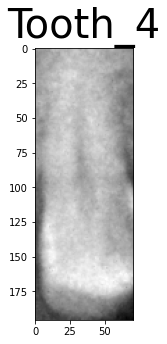

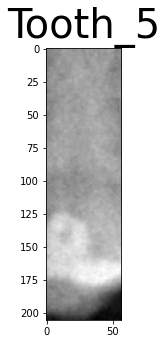

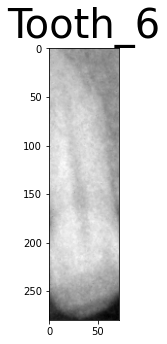

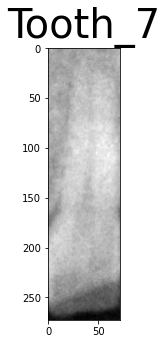

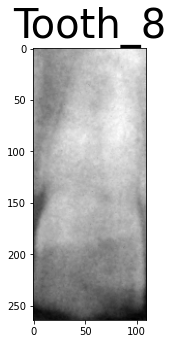

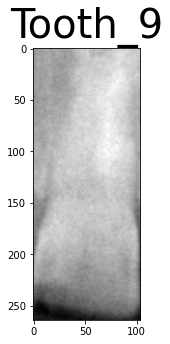

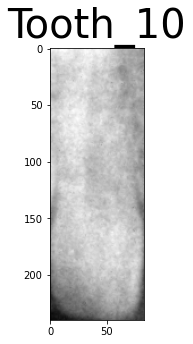

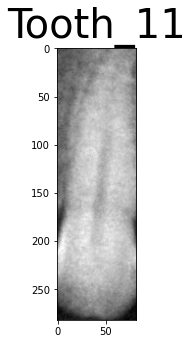

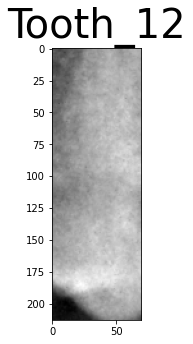

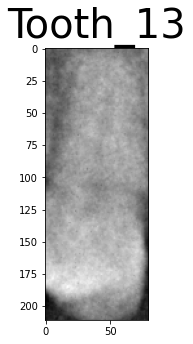

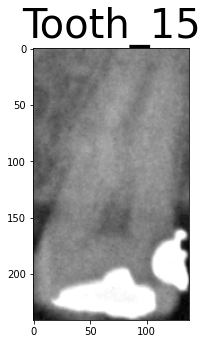

In [15]:
tooth_from_pan_image_list_upper = []

for pp in range(len(upper_tooth_sorted)):
    
    top_left=int(upper_tooth_sorted[pp][0][0]),int(upper_tooth_sorted[pp][0][1])
    top_right=int(upper_tooth_sorted[pp][1][0]),int(upper_tooth_sorted[pp][1][1])
    bottom_right=int(upper_tooth_sorted[pp][2][0]),int(upper_tooth_sorted[pp][2][1])
    bottom_left=int(upper_tooth_sorted[pp][3][0]),int(upper_tooth_sorted[pp][3][1])
    

    
    height = int(distance.euclidean(top_left, bottom_left))
    width = int(distance.euclidean(top_left, top_right))
    
    #src_pts = upper_tooth_sorted[pp]
    src_pts = np.array([[top_left[0], top_left[1]],
                        [top_right[0], top_right[1]],
                        [bottom_right[0], bottom_right[1]],
                        [bottom_left[0],bottom_left[1]]], dtype="float32")
    dst_pts = np.array([[0, 0],[width-1, 0],[width-1, height-1],[0,height-1]], dtype="float32")
   

    
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(original_image, M, (width, height))
    
    tooth_from_pan_image_list_upper.append(warped)


print(len(tooth_from_pan_image_list_upper))


###Please name the images based on the original tooth number###########


for i in range(len(tooth_from_pan_image_list_upper)):
    
    if i==0:
        plt.figure(figsize = (5,5))
        plt.title("Tooth_" + str(i+2), fontsize = 40)
        plt.imsave('sample_images/self_pan_upper/' + "upper_" + str(i+2) +'.png', tooth_from_pan_image_list_upper[i] , cmap= 'gray')
        plt.imshow(tooth_from_pan_image_list_upper[i], cmap= 'gray')
    
    if i>=1 and i<=10:
        plt.figure(figsize = (5,5))
        plt.title("Tooth_" + str(i+3), fontsize = 40)
        plt.imsave('sample_images/self_pan_upper/' + "upper_" + str(i+3) +'.png', tooth_from_pan_image_list_upper[i] , cmap= 'gray')
        plt.imshow(tooth_from_pan_image_list_upper[i], cmap= 'gray')
        
    if i==11:
        plt.figure(figsize = (5,5))
        plt.title("Tooth_" + str(i+4), fontsize = 40)
        plt.imsave('sample_images/self_pan_upper/' + "upper_" + str(i+4) +'.png', tooth_from_pan_image_list_upper[i] , cmap= 'gray')
        plt.imshow(tooth_from_pan_image_list_upper[i], cmap= 'gray')
    
        
    



# Save upper tooth from self panoramic image for self-matching

12


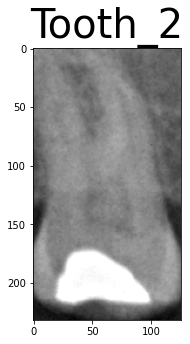

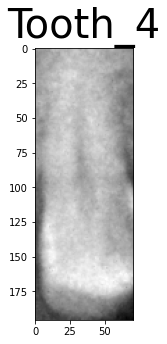

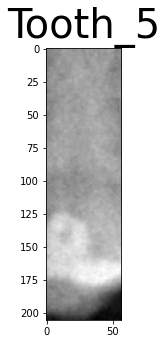

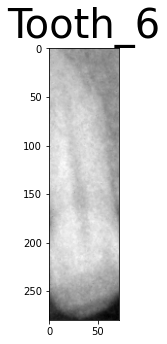

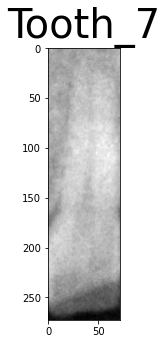

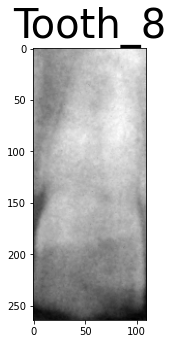

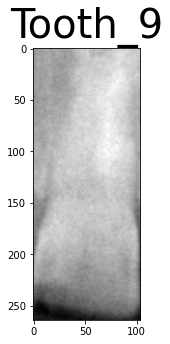

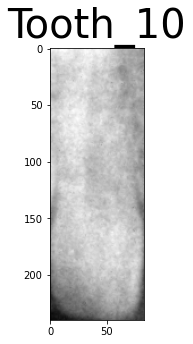

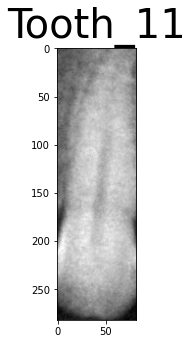

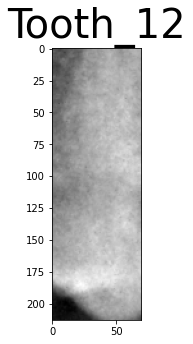

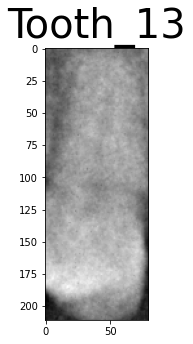

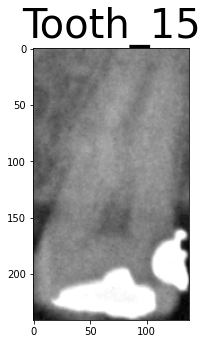

In [17]:
tooth_from_pan_image_list_lower = []

for pp in range(len(lower_tooth_sorted)):
    
    top_left=int(lower_tooth_sorted[pp][0][0]),int(lower_tooth_sorted[pp][0][1])
    top_right=int(lower_tooth_sorted[pp][1][0]),int(lower_tooth_sorted[pp][1][1])
    bottom_right=int(lower_tooth_sorted[pp][2][0]),int(lower_tooth_sorted[pp][2][1])
    bottom_left=int(lower_tooth_sorted[pp][3][0]),int(lower_tooth_sorted[pp][3][1])
    
    
    height = int(distance.euclidean(top_left, bottom_left))
    width = int(distance.euclidean(top_left, top_right))
    

    #src_pts = lower_tooth_sorted[pp]
    src_pts = np.array([[top_left[0], top_left[1]],
                        [top_right[0], top_right[1]],
                        [bottom_right[0], bottom_right[1]],
                        [bottom_left[0],bottom_left[1]]], dtype="float32")
    dst_pts = np.array([[0, 0],[width-1, 0],[width-1, height-1],[0,height-1]], dtype="float32")
    
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(original_image, M, (width, height))
    

    #plt.imshow(warped)
    tooth_from_pan_image_list_lower.append(warped)


print(len(tooth_from_pan_image_list_lower))


for i in range(len(tooth_from_pan_image_list_lower)):
    if i==0:
        plt.figure(figsize = (5,5))
        plt.title("Tooth_" + str(i+2), fontsize = 40)
        plt.imsave('sample_images/self_pan_lower/' + "lower_" + str(i+2) +'.png', tooth_from_pan_image_list_upper[i] , cmap= 'gray')
        plt.imshow(tooth_from_pan_image_list_upper[i], cmap= 'gray')
    
    if i>=1 and i<=10:
        plt.figure(figsize = (5,5))
        plt.title("Tooth_" + str(i+3), fontsize = 40)
        plt.imsave('sample_images/self_pan_lower/' + "lower_" + str(i+3) +'.png', tooth_from_pan_image_list_upper[i] , cmap= 'gray')
        plt.imshow(tooth_from_pan_image_list_upper[i], cmap= 'gray')
        
    if i==11:
        plt.figure(figsize = (5,5))
        plt.title("Tooth_" + str(i+4), fontsize = 40)
        plt.imsave('sample_images/self_pan_lower/' + "lower_" + str(i+4) +'.png', tooth_from_pan_image_list_upper[i] , cmap= 'gray')
        plt.imshow(tooth_from_pan_image_list_upper[i], cmap= 'gray')
    
        
